<a href="https://colab.research.google.com/github/MareevaMI/PDA_SOL/blob/main/retail_demand_forecasting_2_(4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import plotly.express as px
import plotly.graph_objects as go

# Построение модели прогнозирования спроса с помощью BigQuery ML

В этой записной книжке показано, как обучать, развертывать и оценивать модель временных рядов с помощью BigQuery ML. Он предоставляет комплексное решение для прогнозирования нескольких продуктов. Используя общедоступный набор данных [данные о продажах спиртных напитков в Айове](https://www.kaggle.com/datasets/residentmario/iowa-liquor-sales), вы используете один SQL-запрос для создания пяти моделей временных рядов, где каждая модель прогнозирует розничные продажи одного алкогольного напитка.

К концу этого блокнота вы будете знать, как:
* Предварительно обработайте данные временных рядов в правильном формате, необходимом для создания модели.
* Обучите модель временных рядов в BigQuery ML.
* Оцените модель.
* Делайте прогнозы будущего спроса с помощью модели.
* Создайте панель мониторинга для визуализации прогнозируемого спроса с помощью Data Studio.

## Setup
### Create a BigQuery dataset
Создайте в своем проекте набор данных под названием `TS`
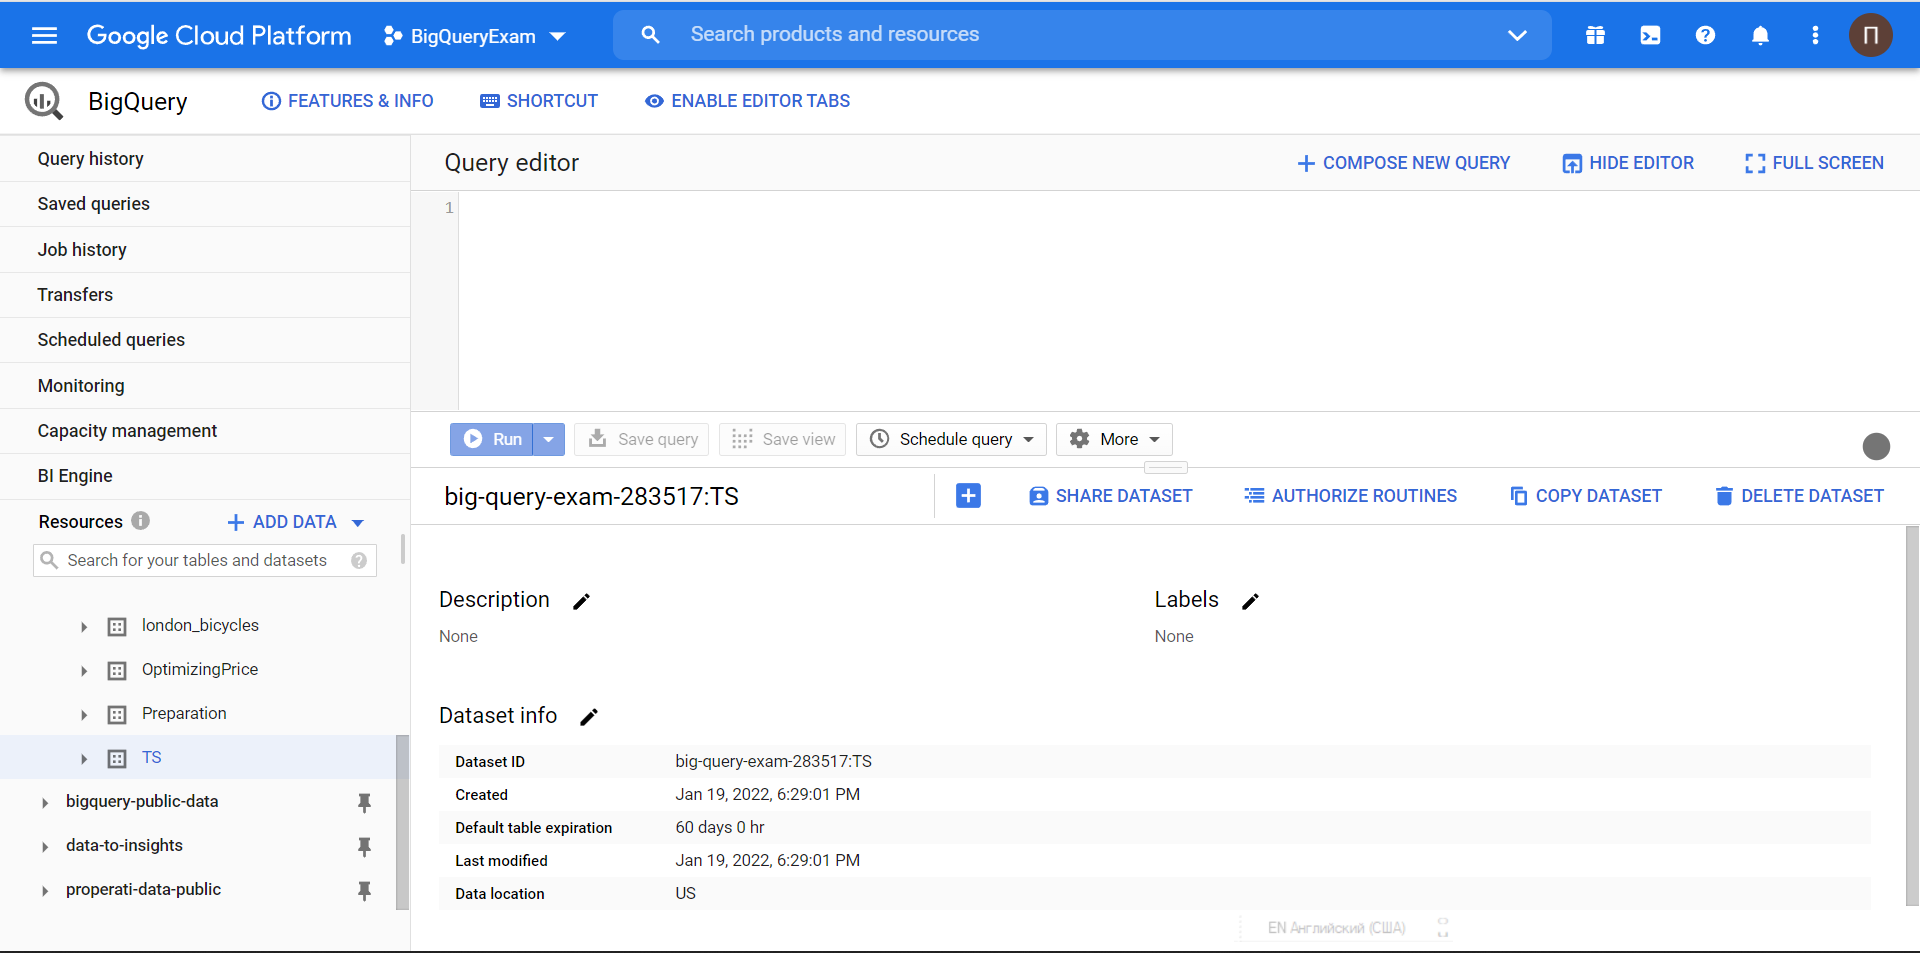

In [2]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


### PIP Install Packages

In [3]:
!pip install google-cloud-bigquery google-cloud-bigquery-storage --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.7/236.7 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: google-cloud-bigquery
    Found existing installation: google-cloud-bigquery 3.21.0
    Uninstalling google-cloud-bigquery-3.21.0:
      Successfully uninstalled google-cloud-bigquery-3.21.0


### Настройка параметров среды GCP

Обновите следующие переменные, чтобы отразить значения для вашей среды GCP:

* PROJECT_ID: идентификатор проекта Google Cloud, который вы используете для реализации этого решения.
* REGION: регион, используемый для набора данных BigQuery.

In [4]:
PROJECT_ID = 'super-417411' # Change to your project.
REGION = 'US'

### Импорт библиотек

In [5]:
from google.cloud import bigquery
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

#pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Подготовить обучающие данные

Вы обучаете модели временных рядов на наборе данных, содержащем транзакционные данные. Каждая строка представляет собой транзакцию по одному продукту, определяемому значением item_description, и содержит такие сведения, как количество проданных бутылок и сумма продаж в долларах. На следующих шагах вы используете количество проданных бутылок для прогнозирования спроса на продукт.

_Примечание_: Jupyter запускает ячейки, начинающиеся с %%bigquery, как SQL-запросы.

In [6]:
!pip install db-dtypes

In [7]:
%%bigquery --project $PROJECT_ID

SELECT
    invoice_and_item_number,
    date,
    store_number,
    item_description,
    bottles_sold,
    sale_dollars
FROM
# `my-project-super-416011.TS.iowa_liquor_sales`
  `bigquery-public-data.iowa_liquor_sales.sales`
  Limit 5

Query is running:   0%|          |

Downloading:   0%|          |

,invoice_and_item_number,date,store_number,item_description,bottles_sold,sale_dollars
0,INV-62755800099,2023-09-28,6129,JAGERMEISTER LIQUEUR MINI MEISTERS,1,8.45
1,INV-55032200016,2023-01-17,6231,JAGERMEISTER LIQUEUR MINI MEISTERS,1,8.45
2,INV-67927000017,2024-03-05,5866,JAGERMEISTER LIQUEUR MINI MEISTERS,1,8.45
3,INV-32432100011,2020-12-04,5821,JAGERMEISTER LIQUEUR MINI MEISTERS,1,7.40
4,INV-61865000058,2023-09-01,5327,JAGERMEISTER LIQUEUR MINI MEISTERS,1,8.45


### Установите даты начала и окончания для обучающих данных

Вы можете настроить параметры `TRAININGDATA_STARTDATE` и `TRAININGDATA_ENDDATE`, чтобы указать даты начала/окончания training data:

In [8]:
ARIMA_PARAMS = {
    'TRAININGDATA_STARTDATE': '2018-01-01',
    'TRAININGDATA_ENDDATE': '2021-12-30',
}
ARIMA_PARAMS

{'TRAININGDATA_STARTDATE': '2018-01-01', 'TRAININGDATA_ENDDATE': '2021-12-30'}

### Запишите обучающие данные в таблицу

Если вы просмотрите на training data, вы увидите, что в некоторые дни нет транзакций для данного продукта. Чтобы вам не приходилось выполнять дополнительную предварительную обработку, BigQuery ML автоматически обрабатывает следующие ситуации:

* Отсутствующие значения: значения вводятся с использованием локальной [линейной интерполяции] (https://en.wikipedia.org/wiki/Linear_interpolation).
* Дублированные временные метки: значения усредняются по повторяющимся временным меткам.
* Аномалии и выбросы: значения стандартизированы с использованием local [z-показателей] (https://en.wikipedia.org/wiki/Standard_score).

In [9]:
%%bigquery df --params $ARIMA_PARAMS  --project $PROJECT_ID

CREATE OR REPLACE TABLE TS.training_data AS (
    WITH topsellingitems AS(
         SELECT
            item_description,
            count(item_description) cnt_transactions
        FROM
            `bigquery-public-data.iowa_liquor_sales.sales`
        GROUP BY
            item_description
        ORDER BY cnt_transactions DESC
        LIMIT 5 #Top N
    )
    SELECT
        date,
        item_description AS item_name,
        SUM(bottles_sold) AS total_amount_sold #сумма проданых бутылок
    FROM
        `bigquery-public-data.iowa_liquor_sales.sales`
    GROUP BY
        date, item_name
    HAVING
        date BETWEEN @TRAININGDATA_STARTDATE AND @TRAININGDATA_ENDDATE
        AND item_description IN (SELECT item_description FROM topsellingitems)
    );

SELECT
    date,
    item_name,
    total_amount_sold
FROM
     TS.training_data
ORDER BY item_name, date

Query is running:   0%|          |

Downloading:   0%|          |

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5274 entries, 0 to 5273
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date               5274 non-null   dbdate
 1   item_name          5274 non-null   object
 2   total_amount_sold  5274 non-null   Int64 
dtypes: Int64(1), dbdate(1), object(1)
memory usage: 128.9+ KB


### Постройте историю продаж целевых алкогольных напитков

Сохраните training data как `dfhistorical` Pandas dataframe:

In [11]:
%%bigquery dfhistorical --project $PROJECT_ID

SELECT
    *
FROM TS.training_data

Query is running:   0%|          |

Downloading:   0%|          |

In [12]:
dfhistorical

,date,item_name,total_amount_sold
0,2018-12-04,BLACK VELVET,6203
1,2019-11-04,BLACK VELVET,3473
2,2021-09-24,BLACK VELVET,3052
3,2018-05-16,BLACK VELVET,8597
4,2019-05-29,BLACK VELVET,9657
...,...,...,...
5269,2019-09-18,FIREBALL CINNAMON WHISKEY,1578
5270,2021-07-13,FIREBALL CINNAMON WHISKEY,8811
5271,2021-06-17,FIREBALL CINNAMON WHISKEY,9813
5272,2018-09-05,FIREBALL CINNAMON WHISKEY,2050


Используя обучающие данные, постройте историю продаж спиртных напитков:

In [13]:
import plotly.express as px
fig = px.line(dfhistorical.sort_values(by=['date'], ascending=[True]), x='date', y='total_amount_sold', facet_row='item_name', color='item_name',
              title='item_name', width=None, height=2000)
fig

In [14]:
fig = px.line(dfhistorical.sort_values(by=['date'], ascending=[True]), x='date', y='total_amount_sold',  color='item_name')
fig

## Обучите модель

Поскольку вы обучаете модель для нескольких продуктов в одном операторе создания модели, вы должны указать столбец `item_name` для [TIME_SERIES_ID_COL](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-time-series#time_series_id_col). Если бы вы прогнозировали только один элемент, вам не нужно было бы указывать `TIME_SERIES_ID_COL`. Дополнительные сведения см. в [документации по созданию модели временных рядов BigQuery ML](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-time-series#create_model_syntax). .

Вы также можете учитывать влияние праздников при моделировании временных рядов в BigQuery ML. По умолчанию моделирование праздничных эффектов отключено. Но поскольку эти данные получены из Соединенных Штатов и включают ежедневные данные минимум за один год, вы также можете указать необязательный параметр `HOLIDAY_REGION`. При включенных праздничных эффектах всплески и провалы, появляющиеся во время праздников, больше не будут рассматриваться как аномалии. Полный список праздничных регионов можно найти в [документации HOLIDAY_REGION](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-time-series#holiday_region). ).



In [15]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE MODEL TS.arima_model

OPTIONS(
  MODEL_TYPE='ARIMA_PLUS',
  TIME_SERIES_TIMESTAMP_COL='date',
  TIME_SERIES_DATA_COL='total_amount_sold',
  TIME_SERIES_ID_COL='item_name',
  HOLIDAY_REGION='US'
) AS

SELECT
    date,
    item_name,
    total_amount_sold
FROM
   TS.training_data

Query is running:   0%|          |

""


### Оценить модель

Используйте функцию [ML.EVALUATE](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate), чтобы просмотреть показатели оценки всех созданных моделей.

Столбцы non_seasonal_{`p`,`d`,`q`} и `has_drift` определяют модель временных рядов. Столбцы log_likelihood, `AIC`, и `variance` относятся к процессу подбора модели. В процессе подбора наилучшая модель определяется с помощью [алгоритма auto.ARIMA](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-time-series#auto_arima ), по одному для каждого временного ряда.

In [16]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  ML.EVALUATE(MODEL TS.arima_model)

Query is running:   0%|          |

Downloading:   0%|          |

,item_name,non_seasonal_p,non_seasonal_d,non_seasonal_q,has_drift,log_likelihood,AIC,variance,seasonal_periods,has_holiday_effect,has_spikes_and_dips,has_step_changes
0,BLACK VELVET,0,1,5,False,-11857.009725,23726.019450,673846.826185,"[WEEKLY, YEARLY]",True,True,True
1,FIREBALL CINNAMON WHISKEY,0,1,5,False,-11833.325947,23678.651894,654498.150131,"[WEEKLY, YEARLY]",True,True,True
2,FIVE O'CLOCK VODKA,3,1,2,False,-9949.060873,19910.121747,49425.711886,"[WEEKLY, YEARLY]",True,False,True
3,HAWKEYE VODKA,4,1,1,True,-10863.773787,21741.547574,173364.161275,"[WEEKLY, YEARLY]",True,True,True
4,TITOS HANDMADE VODKA,0,1,5,True,-11689.499986,23392.999971,534560.352326,"[WEEKLY, YEARLY]",True,True,True


Вы можете видеть, что было обучено пять моделей, по одной для каждого из продуктов в столбце item_name. Каждая модель имеет свои собственные гиперпараметры «p, d, q», и обнаруженная сезонность для этих пяти моделей  `WEEKLY`(ЕЖЕНЕДЕЛЬНО).

## Прогнозирование

Создайте прогнозы с помощью [ML.FORECAST](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-forecast), который прогнозирует следующие _n_ значений, как указано в  параметре `horizon`. Вы также можете дополнительно изменить параметр `confidence_level`, чтобы изменить процент будущих значений, которые попадают в интервал прогнозирования. Вы сохраняете данные прогноза в датафрейм `dfforecast`, чтобы вы могли построить их на следующем шаге.


In [17]:
%%bigquery dfforecast --project $PROJECT_ID

DECLARE HORIZON STRING DEFAULT "30"; #number of values to forecast
DECLARE CONFIDENCE_LEVEL STRING DEFAULT "0.95";
# Выполняет динамическую инструкцию SQL на лету
EXECUTE IMMEDIATE format("""
    SELECT
      *
    FROM
       ML.FORECAST(MODEL TS.arima_model,
                  STRUCT(%s AS horizon,
                         %s AS confidence_level)
                 )
    """,HORIZON,CONFIDENCE_LEVEL)

Query is running:   0%|          |

Downloading:   0%|          |

In [18]:
dfforecast

,item_name,forecast_timestamp,forecast_value,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,confidence_interval_lower_bound,confidence_interval_upper_bound
0,BLACK VELVET,2021-12-31 00:00:00+00:00,7309.842018,820.881737,0.95,5703.821302,8915.862735,5703.821302,8915.862735
1,BLACK VELVET,2022-01-01 00:00:00+00:00,1692.481552,909.860961,0.95,-87.623287,3472.586391,-87.623287,3472.586391
2,BLACK VELVET,2022-01-02 00:00:00+00:00,-100.883634,917.643598,0.95,-1896.214877,1694.447608,-1896.214877,1694.447608
3,BLACK VELVET,2022-01-03 00:00:00+00:00,3188.712688,1026.701702,0.95,1180.013836,5197.411540,1180.013836,5197.411540
4,BLACK VELVET,2022-01-04 00:00:00+00:00,4442.206349,1261.690110,0.95,1973.762525,6910.650173,1973.762525,6910.650173
...,...,...,...,...,...,...,...,...,...
145,TITOS HANDMADE VODKA,2022-01-25 00:00:00+00:00,5077.356754,1121.177345,0.95,2883.820265,7270.893242,2883.820265,7270.893242
146,TITOS HANDMADE VODKA,2022-01-26 00:00:00+00:00,4826.190840,1121.177345,0.95,2632.654351,7019.727329,2632.654351,7019.727329
147,TITOS HANDMADE VODKA,2022-01-27 00:00:00+00:00,4926.952592,1121.177345,0.95,2733.416103,7120.489081,2733.416103,7120.489081
148,TITOS HANDMADE VODKA,2022-01-28 00:00:00+00:00,5447.200690,1121.177345,0.95,3253.664201,7640.737180,3253.664201,7640.737180


Поскольку для параметра `horizon` установлено значение 30, результат равен 30 x (количество элементов) с одной строкой на прогнозируемое значение:

In [19]:
print(f"Number of rows: {dfforecast.shape[0]}")

Number of rows: 150


In [20]:
fig = px.line(dfforecast.sort_values(by=['forecast_timestamp'], ascending=[True]), x='forecast_timestamp', y='forecast_value', color='item_name')
fig

#### Проверить коэффициенты модели

Вы можете просмотреть коэффициенты каждой из моделей временных рядов, используя [ML.ARIMA_COEFFICIENTS](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-arima-coefficients) https://ru.wikipedia.org/wiki/ARIMA.

Для каждой из моделей значение `ar_coefficients` показывает коэффициенты модели авторегрессионной (AR) части модели временных рядов. Точно так же значение `ma_coefficients` показывает коэффициенты модели скользящей средней (MA) - составной части модели. Оба этих значения являются массивами, и их длины равны `non_seasonal_p` и `non_seasonal_q` соответственно. Значение `intercept_or_drift` является постоянным членом в модели временных рядов.

In [21]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
   ML.ARIMA_COEFFICIENTS(MODEL TS.arima_model)

Query is running:   0%|          |

Downloading:   0%|          |

,item_name,ar_coefficients,ma_coefficients,intercept_or_drift
0,BLACK VELVET,[],"[-0.5219426866172484, -0.6233393869130895, 0.7...",0.000000
1,FIREBALL CINNAMON WHISKEY,[],"[-0.6823709247667195, -0.34755221794535224, 0....",0.000000
2,FIVE O'CLOCK VODKA,"[-0.4884178090887415, 0.264155548079893, -0.08...","[-0.12874201621370993, -0.799661781266047]",0.000000
3,HAWKEYE VODKA,"[0.4409059458029585, 0.06236927360630265, 0.02...",[-0.9833655672380398],-0.391009
4,TITOS HANDMADE VODKA,[],"[-0.43773930823061324, -0.6973296891646542, 0....",1.944366


#### Сопоставьте прогнозируемые прогнозы с историческими данными

Постройте прогнозы, используя датафрейм dfhistorical, который содержит исторические данные, которые вы использовали для обучения, и датафрейм dfforecast, содержащий данные прогноза:

In [ ]:
dfhistorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5274 entries, 0 to 5273
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date               5274 non-null   dbdate
 1   item_name          5274 non-null   object
 2   total_amount_sold  5274 non-null   Int64 
dtypes: Int64(1), dbdate(1), object(1)
memory usage: 128.9+ KB


In [ ]:
dfhistorical.date = pd.to_datetime(dfhistorical.date)

In [ ]:
dfhistorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5274 entries, 0 to 5273
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               5274 non-null   datetime64[ns]
 1   item_name          5274 non-null   object        
 2   total_amount_sold  5274 non-null   Int64         
dtypes: Int64(1), datetime64[ns](1), object(1)
memory usage: 128.9+ KB


#### Plot the forecasted predictions against the actual data

Сохраните фактические данные о продажах в `dfactual` dataframe Pandas:

In [22]:
%%bigquery dfactual --params $ARIMA_PARAMS --project $PROJECT_ID

DECLARE HORIZON STRING DEFAULT "30"; #number of values to forecast

SELECT
    date,
    item_description AS item_name,
    SUM(bottles_sold) AS total_amount_sold
FROM
    `bigquery-public-data.iowa_liquor_sales.sales`
GROUP BY
    date, item_name
HAVING
    date BETWEEN DATE_ADD(@TRAININGDATA_ENDDATE,
                              INTERVAL 1 DAY)
            AND DATE_ADD(@TRAININGDATA_ENDDATE,
                             INTERVAL 1+CAST(HORIZON AS INT64) DAY)
ORDER BY
    date;

Query is running:   0%|          |

Downloading:   0%|          |

In [23]:
dfactual

,date,item_name,total_amount_sold
0,2021-12-31,NEFARIOUS RYE WHISKEY,6
1,2021-12-31,FIREBALL CINNAMON WHISKEY,10641
2,2021-12-31,CANADIAN MIST WHISKY PET,53
3,2021-12-31,BAILEYS STRAWBERRIES & CREAM,23
4,2021-12-31,SEAGRAMS 7 CROWN,700
...,...,...,...
24151,2022-01-30,KETEL ONE BOTANICAL CUCUMBER & MINT,4
24152,2022-01-30,ABERLOUR 12YR,6
24153,2022-01-30,STOLI LIME,2
24154,2022-01-30,MYERS'S ORIGINAL DARK RUM PET,2


Постройте прогнозные прогнозы по обучающим данным и фактическим значениям, используя dataframe `dfhistorical`, который содержит исторические данные, dataframe `dfforecast`, содержащий данные прогноза, и фрейм данных dfactual, содержащий фактические данные о продажах:

In [ ]:
#itemslist = list(dfhistorical.item_name.unique())

#for item in itemslist:
#    datah = dfhistorical[dfhistorical.item_name==item].sort_values('date')
#    dataf = dfforecast[dfforecast.item_name==item].sort_values(['forecast_timestamp'])
#    dataa = dfactual[dfactual.item_name==item].sort_values('date')
#    plot_historical_and_forecast(input_timeseries = datah,
#                             timestamp_col_name = "date",
#                             data_col_name = "total_amount_sold",
#                             forecast_output = dataf,
#                             actual = dataa,
#                             title = item,
#                             plotstartdate = "2017-01-01")

## Создайте dashboard с помощью Data Studio

Выполните действия, описанные в этом разделе, чтобы создать dashboard  прогноза с помощью Data Studio.

### Создать dashboard

Создайте dashboard, объединяющую исторические и прогнозные данные. SQL перед предложением `UNION ALL` выбирает исторические данные. SQL после предложения `UNION ALL` использует `ML.FORECAST` для генерации прогнозируемого значения и интервала прогнозирования. В запросе используются разные поля для `history_value` и `forecasted_value`, так что вы можете отобразить их разными цветами на следующем шаге.

In [24]:
%%bigquery --params $ARIMA_PARAMS  --project $PROJECT_ID

CREATE OR REPLACE VIEW TS.outputdata_datastudio AS (
  SELECT
    date AS timestamp,
    item_name,
    total_amount_sold AS history_value,
    NULL AS forecast_value,
    NULL AS prediction_interval_lower_bound,
    NULL AS prediction_interval_upper_bound
  FROM
     TS.training_data
  UNION ALL
  SELECT
    EXTRACT(DATE
    FROM
      forecast_timestamp) AS timestamp,
    item_name,
    NULL AS history_value,
    forecast_value,
    prediction_interval_lower_bound,
    prediction_interval_upper_bound
  FROM
    ML.FORECAST(MODEL TS.arima_model,
      STRUCT(30 AS horizon, 0.95 AS confidence_level))
  ORDER BY timestamp
  )

Query is running:   0%|          |

""


In [25]:
%%bigquery df --params $ARIMA_PARAMS --project $PROJECT_ID

SELECT
    date AS timestamp,
    item_name,
    total_amount_sold AS history_value,
    NULL AS forecast_value,
    NULL AS prediction_interval_lower_bound,
    NULL AS prediction_interval_upper_bound
  FROM
     TS.training_data
  UNION ALL
  SELECT
    EXTRACT(DATE
    FROM
      forecast_timestamp) AS timestamp,
    item_name,
    NULL AS history_value,
    forecast_value,
    prediction_interval_lower_bound,
    prediction_interval_upper_bound
  FROM
    ML.FORECAST(MODEL TS.arima_model,
      STRUCT(30 AS horizon, 0.9 AS confidence_level))
  ORDER BY timestamp
 # )

Query is running:   0%|          |

Downloading:   0%|          |

In [26]:
df

,timestamp,item_name,history_value,forecast_value,prediction_interval_lower_bound,prediction_interval_upper_bound
0,2018-01-02,BLACK VELVET,3046,NaN,NaN,NaN
1,2018-01-02,HAWKEYE VODKA,2530,NaN,NaN,NaN
2,2018-01-02,FIVE O'CLOCK VODKA,1733,NaN,NaN,NaN
3,2018-01-02,TITOS HANDMADE VODKA,1883,NaN,NaN,NaN
4,2018-01-02,FIREBALL CINNAMON WHISKEY,1904,NaN,NaN,NaN
...,...,...,...,...,...,...
5419,2022-01-29,HAWKEYE VODKA,<NA>,1615.366930,762.774008,2467.959852
5420,2022-01-29,BLACK VELVET,<NA>,2456.833438,374.572251,4539.094625
5421,2022-01-29,TITOS HANDMADE VODKA,<NA>,3426.231316,1584.057137,5268.405494
5422,2022-01-29,FIVE O'CLOCK VODKA,<NA>,1212.415156,804.075212,1620.755100


In [27]:
import numpy as np

df = df.fillna(np.nan).replace([np.nan], [None])

In [28]:
df

,timestamp,item_name,history_value,forecast_value,prediction_interval_lower_bound,prediction_interval_upper_bound
0,2018-01-02,BLACK VELVET,3046,None,None,None
1,2018-01-02,HAWKEYE VODKA,2530,None,None,None
2,2018-01-02,FIVE O'CLOCK VODKA,1733,None,None,None
3,2018-01-02,TITOS HANDMADE VODKA,1883,None,None,None
4,2018-01-02,FIREBALL CINNAMON WHISKEY,1904,None,None,None
...,...,...,...,...,...,...
5419,2022-01-29,HAWKEYE VODKA,None,1615.36693,762.774008,2467.959852
5420,2022-01-29,BLACK VELVET,None,2456.833438,374.572251,4539.094625
5421,2022-01-29,TITOS HANDMADE VODKA,None,3426.231316,1584.057137,5268.405494
5422,2022-01-29,FIVE O'CLOCK VODKA,None,1212.415156,804.075212,1620.7551


In [29]:
fig = px.line(df.sort_values(by=['timestamp'], ascending=[True]), x='timestamp', y=['forecast_value', 'history_value'])
fig

In [30]:
fig = px.line(df.sort_values(by=['timestamp'], ascending=[True]), x='timestamp', y=['forecast_value', 'history_value','prediction_interval_lower_bound' , 'prediction_interval_upper_bound'], facet_row='item_name',
              title='item_name', width=None, height=2000)
fig

In [31]:
fig = px.line(df.sort_values(by=['timestamp'], ascending=[True]), x='timestamp', y=['forecast_value', 'history_value'], color='item_name')
fig

### Экспорт данных в DataStudio

1. На панели **Resources** [консоли BigQuery](https://console.cloud.google.com/bigquery) перейдите к представлению `bqmlforecast.outputdata_datastudio` и выберите его.
1. Нажмите **Export**, а затем выберите **Explore with Data Studio**. В браузере откроется новая вкладка.

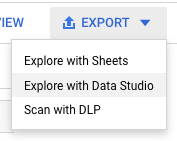


### Установить тип диаграммы

На панели **Диаграмма** найдите значок **Диаграмма временных рядов** и щелкните его, как показано на следующем screenshot:

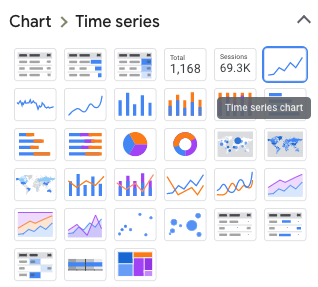

### Установить данные приборной панели

1. На вкладке **Данные** найдите раздел **Метрика**.
1. Нажмите **Добавить показатель**, чтобы добавить поле `history_value`.
1. Повторите шаг 2, чтобы добавить поля `forecast_value`, `prediction_interval_lower_bound` и `prediction_interval_upper_bound`.

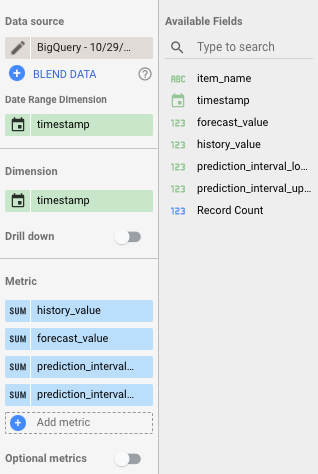

### Установить стиль панели инструментов

1. На вкладке **Стиль** прокрутите вниз до раздела **Общие**.
1. Для параметра **Отсутствующие данные** выберите **Линейная интерполяция**.

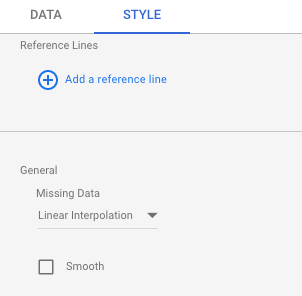

### Установить фильтр панели

1. На панели **Фильтр** нажмите **Перетащите сюда поля показателей или параметров, чтобы создать фильтры**, и выберите `item_name`.
1. Нажмите «item_name», чтобы увидеть список значений для фильтрации.
1. Выберите **Five O’clock Vodka**, чтобы просмотреть данные временного ряда только для этого продукта.

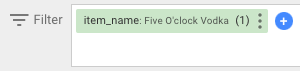

### Просмотрите информационную панель (dashboard)

После выполнения этих шагов на левой панели появится следующий график. Временной ряд входной истории выделен синим цветом, а прогнозируемый ряд — зеленым. Интервал прогнозирования — это область между рядом нижней границы и рядом верхней границы.

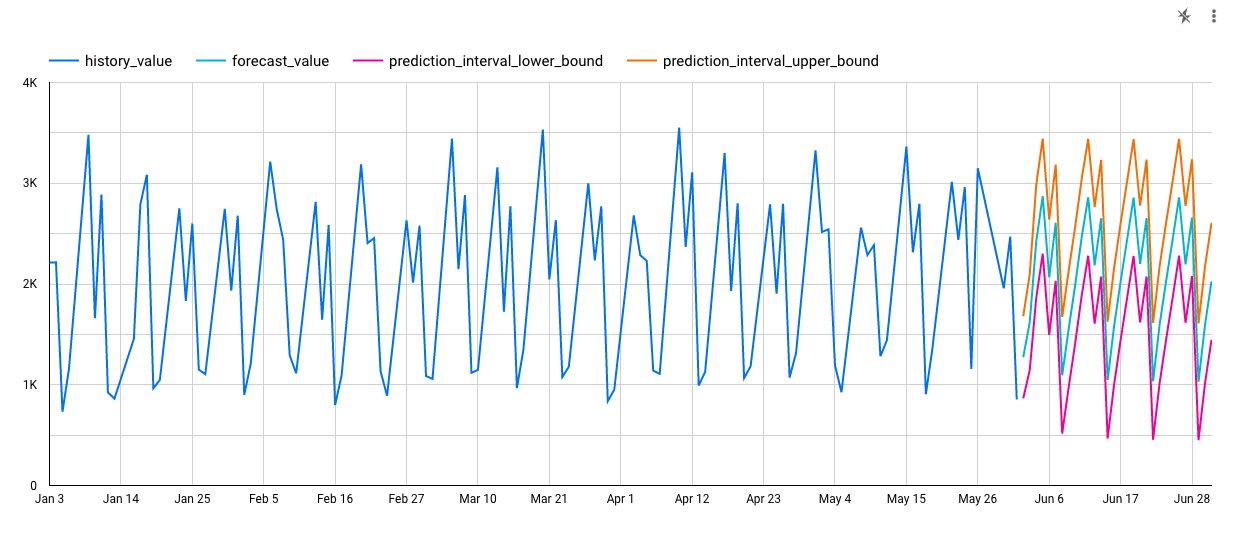